# 료코 박사로 부터의 메시지가 있습니다
2-A 연습에서 라이츠 아웃 퍼즐을 이해하는데 성공하셨나요?  
제가 있는 방의 바닥은 3×3 타일로 되어 있고, 하나의 타일이 하나의 양자 비트에 해요. 
기저 상태와 들뜸 상태를 왔다갔다 하는 양자 비트가 몇 개가 있는데 관찰한 결과 네 가지 종류로 바닥 타일의 상태가 변화하고 있었어요. 제가 여기를 무사히 통과할 수 있도록 우선 양자 비트를 모두 바닥 상태로 만들어 주세요! 양자 상태는 곧바로 무너져 버리기 때문에, 모든 스위치를 계속 누르고 있을 시간이 없어요.3번의 스위치 조작으로 양자 비트가 모두 바닥상태가 되는 보드를 찾아 주세요. 부탁해요!

# Week2-B: Four-Lights Out
이 문제에서는 여러 개의 binary 데이터를 동시에 다룹니다. 주어진 4개의 라이츠 아웃 보드가 제약 조건(3번만에 lights out)을 만족하며 풀 수 있는지를, 하나의 양자 회로에서 동시에 판단할 수 있도록 고민해봅시다.

예를 들어 아래의 4개의 보드 중에서 1번의 스위치 조작으로 해결 할 수 있는 보드를 발견하는 방법을 생각해 봅시다. 네개의 보드의 초기 상태는 아래의 2차원 배열로 주어지며 0과 1이 각각 소등과 점등을 나타내고 있습니다. lightsout4_ex=[Board0],[Board1],[Board2],[Board3]]]

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

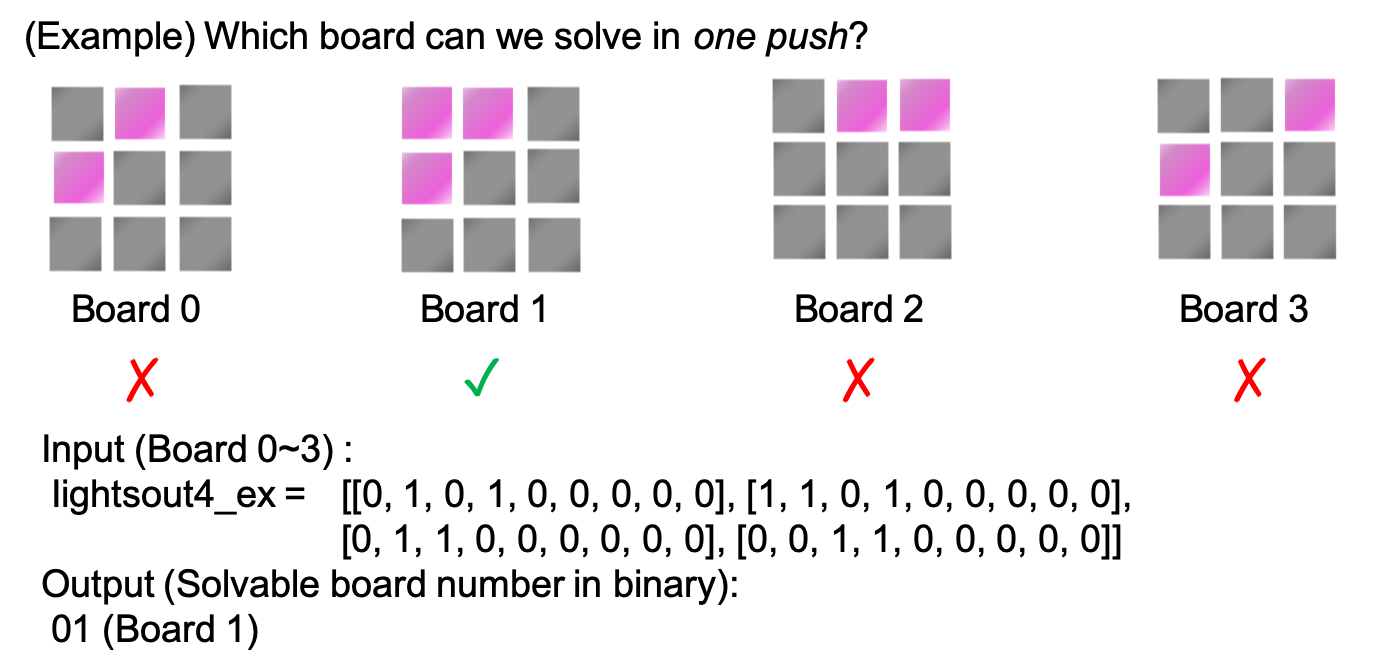

In [6]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

## 풀이 전략
만약 보드가 하나라면 이 문제는 "결정"의 문제가 됩니다.
앞선  2A의 알고리즘을 사용해서 출력에서 1의 개수를 세는 문제가 되겠죠. 
 
보드가 여러 개인 경우 몇 가지 접근방식을 생각할 수 있습니다.   
1. 각각의 보드에 보드 한개용 알고리즘을 번갈아 적용한다.
2. 여러개의 보드 정보를 동시에 유지하고, 한 번의 알고리즘 실행으로 해결한다.
- 이번 챌린지에서는 2번의 접근 방식을 이용해 볼 것입니다.

우선, 어떻게 모든 보드의 정보를 동시에 저장할 수 있을 까요? 
1. 직관적인 방식:　　보드당 9개의 큐비트 * 4 보드 (=36) > 32 큐비트 (ibm_qasm_simulator의 최대 용량은 32큐비트 입니다.).
2. 중첩의 상태를 준비하는 방식:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - 보드의 상태를 만들어내는 회로의 구성은 그때그때 다릅니다.  
3. 해법이 하나인 *qRAM*을 사용하는 방식. 
    - **장점**: 직관적인 적용. 
    - **단점**: 계산량이 많음. 

물론 다른 방법을 사용해서 문제를 해결해도 좋습니다.  
 
여기에서는,*qRAM*에 집중하고 그 특성과 적용 방안을 살펴 보겠습니다.

In [ ]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

## qRAM: 양자 랜덤 액세스 메모리 (양자 램)

고전 컴퓨터에서, RAM(Random Access Memory)은 메모리 주소 $j$가 있고 각 주소 $D_j$에 해당하는 이진법을 기반으로 하는 데이터를 저장하는 휘발성 메모리의 한 유형입니다.

퀀텀 컴퓨터의 [qRAM](https://arxiv.org/abs/0708.1879)의 경우, 주소 큐비트 $a$는 $N$-addresses의 중첩이며 해당 이진 데이터는 데이터 Qubits $d$에 상태 벡터로 저장됩니다.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
우측 상태를 "qRAM"이라고 하고 해당 게이트 작업을 "qRAM 작업"이라고 합니다. 

qRAM 작업에는 $\mathcal{O}(N\log N)$ 게이트가 필요하지만 바이너리 데이터의 중첩 상태를 직관적으로 생성하기 때문에 유용합니다.


qRAM은 이전에 HHL 알고리즘과 같은 다양한 양자 머신러닝 알고리즘에 사용되었습니다. 여기에서는 이 문제를 해결하기 위해 QRAM을 이용하여 그루버 알고리즘을 사용해봅시다.

## 예제: qRAM에서 데이터 찾기
$k_0, k_1, .., k_{n-1}$이(가) 저장되는 $n$ 주소의 qRAM을 준비합니다.
Grover 알고리즘을 사용하여 $m$라는 숫자가 저장되어 있는 주소를 찾습니다.
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM 작업.
위 작업을 위한 qRAM 예시 회로를 살펴 봅시다.

In [ ]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# 주소(adress) 준비하기
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#qRAM　상태 확인하기
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# 출력값 저장
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM 데이터 검색
Grover의 알고리즘을 수행하기 위해 $m$이 포함된 **address Qubit** 기호를 반전합니다. 또한 확산 작업(deffusion) 전에 다른 QRAM 작업으로 **data Qubit**를 초기화해야 합니다.

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
여기에서 $f$는 플래그 큐비트를 의미합니다.  

이 경우에, [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate)를 사용해서 오라클을 구성할 수 있습니다. . 

여기에서 ,[qRAM example](#qRAM-Example:-Find-the-data-from-qRAM)의 전체 회로를 확인할 수 있습니다.

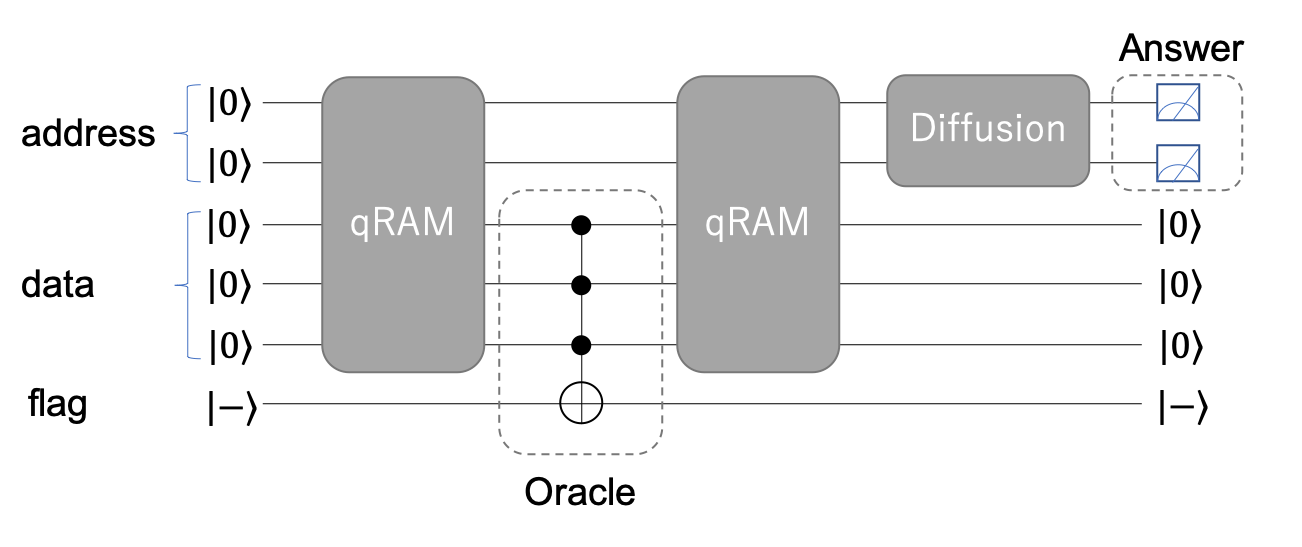

In [3]:
Image('circuit_ex.png')

### qRAM 방식을 사용하기 위해 고려해야 할 것들
위의 설명에서 나이브한 *qRAM 연산* 회로를 소개했습니다.
데이터 구조에 따라, **게이트 조합** (등가 변환) 기술을 사용해서 회로를 단순화 할 수 있습니다.
또한, [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate)와 같은 일부 단순화되어 있는 회로도, 여러분의 *CNOT*-절약에 도움을 줄 수있습니다.

게이트 조합의 몇 가지 예는 다음과 같습니다.

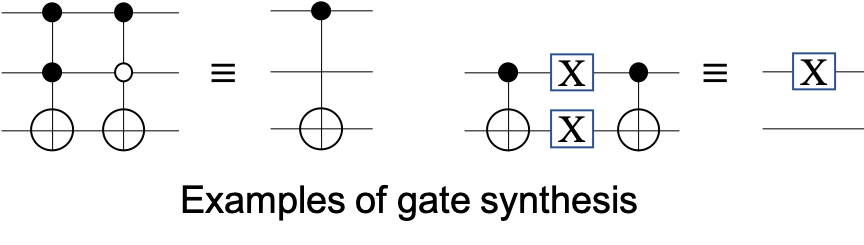

In [4]:
Image('gatesynthesis_ex.png')

## 도전 과제 II-B
4-Lights Out 문제를 qRAM을 사용해 풀어봅시다.  

보드의 초기 상태 lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]가 다음에 주어진 상태와 같이 주어질 때, 3회의 스위치 조작으로 해결할 수 있는 보드 번호를 _2진수_ 형식으로 대답하는 양자 회로를 작성해 주세요. (Board0->00, 1->01, 2->10, 3->11)

아래 그림에 나와 있는 퍼즐을 풀기 위해 양자 회로를 만들어 제출합니다. 제출할 양자 회로에서는 퍼즐을 푸는 `solution`(2비트, 보드번호)만 측정합니다.

솔루션을 제출하려면 "lightsout4"를 입력으로 사용하고 `QuantumCircuit`을 반환하는 함수를 만듭니다. 함수의 이름은 중요하지 않습니다. 다른 데이터 집합을 "lightout4"에 입력해도 작동하는지 확인할 것입니다.

 **추가로, 28 큐비트 이내의 양자회로를 작성해 제출해 주세요.**

입력과 자릿수를 맞추기 위해 다음의 함수를 사용할 수 있습니다.
```python
qc = qc.reverse_bits()
```

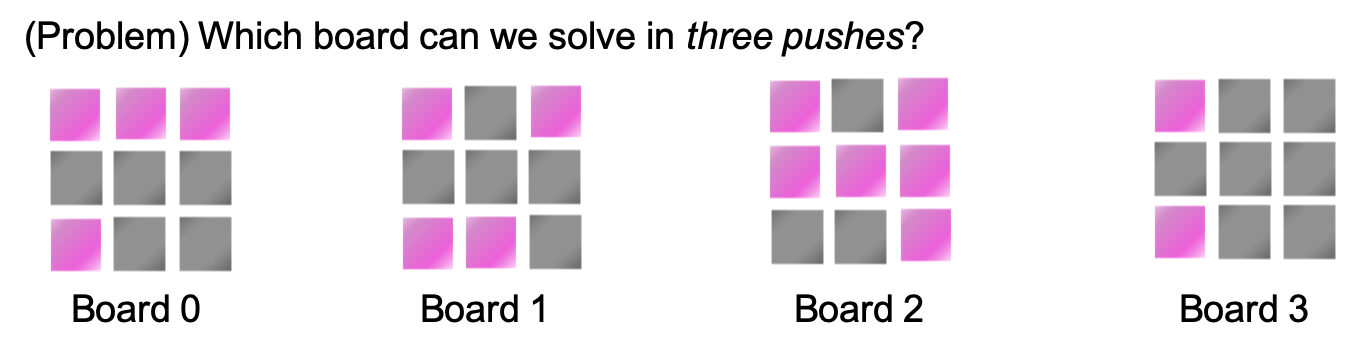

In [5]:
Image('4lightsout_pr.png')

In [ ]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

### 힌트
- [qRAM 자료 검색](#qRAM-Data-search)의 오라클을 적절하게 변형하세요.
- *qRAM 연산*에서의 데이터 쓰기는 임의의 순서로 할 수 있습니다.주소의 _해밍 거리(hamming distance)_ 와 입력되는 데이터를 고려함으로써 게이트 수를 줄일 수 있습니다.


In [ ]:
def week2b_ans_func(lightout4):
    ##### 여기에 회로를 만드세요.
    ####  그리고 이 함수가 다른 입력값에도 동작하도록 일반적으로 만들어 주세요
    
    
    return qc

In [ ]:
# 제출하기
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# prepare_ex2b()함수는 여러분이 만든 회로를 검사합니다.
# prepare_ex2b()는 execute()과 같이 양자회로를 입력값으로 사용합니다.
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# 제일 높은 확률로 나오는 값을 결과로 사용합니다.

In [ ]:
# grade_ex2a를 이용하여 답을 확인하세요.
# 양자비용 (Quantum Cost)는 회로의 효율성을 채점합니다. 마지막 챌린지 문제에서 비용을 줄이는 것이 필요할것입니다.
grade_ex2b(job)

In [ ]:
# submit_ex2b로 답을 제출하세요. 답은 여러번 제출해도 됩니다
submit_ex2b(job)